## Review challenge description

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we are asked build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## Load packages, modules, data and functions

### Load libraries, packages and modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
plt.style.use('fivethirtyeight')

from scipy import stats
from scipy.stats import skew

### Load the two datasets and combine them
The relationship (family member, wife-husband, child-parent, etc.) among passengers is a potential influential factor for the survival rate. For its analysis, the data of all the passengers needs to put together. So the training data and the testing data will be combined.

In [2]:
#load train data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
#create a new column 'Is_train' to differentiate the training data from the testing data, 1 = training, 0 = testing
train_df['Is_train'] = 1
test_df['Is_train'] = 0
#create the 'Survived' column filled with null values in the testing data
#so as to share the same columns as the training data
test_df['Survived'] = np.nan
#combine the trainning data and testing data
full_df = pd.concat([train_df, test_df], ignore_index=True)
# delete the two dataframes which are no longer needed
del train_df, test_df
#show the first and last rows of the combined data
display(full_df.head())
full_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0
1308,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,0


**Finding & analysis:**   
Our full data has 1309 records, one for each passenger. According to [WIKIPEDIA](https://en.wikipedia.org/wiki/Passengers_of_the_Titanic) and [HISTORY ON THE NET](https://www.historyonthenet.com/how-many-people-were-on-the-titanic), the total number of Titanic's passengers was 1,317 or 1316. So our full data covers 99% of the passenger population, with only 7 or 8 missing records.

### Fix some data errors and fill in a couple of missing age values

References:   
[Some SibSp/Parch values are wrong](https://www.kaggle.com/c/titanic/discussion/39787)   
[Miss Erna Alexandra Andersson](https://www.encyclopedia-titanica.org/titanic-survivor/erna-andersson.html)   
[Miss Ida Augusta Margareta Andersson](https://www.encyclopedia-titanica.org/titanic-victim/ida-augusta-margareta-andersson.html)

In [3]:
#fix the data errors according to 
#show the original records
indices = [279, 746, 1283, 987, 1188, 48, 920, 13, 610, 119, 541, 542, 813, 850, 68, 1105, 736, 436, 1058, 86, 147]
full_df.iloc[indices, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train
279,280,1.0,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.2500,NaN,S,1
746,747,0.0,3,"Abbott, Mr. Rossmore Edward",male,16.0,1,1,C.A. 2673,20.2500,NaN,S,1
1283,1284,NaN,3,"Abbott, Master. Eugene Joseph",male,13.0,0,2,C.A. 2673,20.2500,NaN,S,0
987,988,NaN,1,"Cavendish, Mrs. Tyrell William (Julia Florence...",female,76.0,1,0,19877,78.8500,C46,S,0
1188,1189,NaN,3,"Samaan, Mr. Hanna",male,NaN,2,0,2662,21.6792,NaN,C,0
48,49,0.0,3,"Samaan, Mr. Youssef",male,NaN,2,0,2662,21.6792,NaN,C,1
920,921,NaN,3,"Samaan, Mr. Elias",male,NaN,2,0,2662,21.6792,NaN,C,0
13,14,0.0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S,1
610,611,0.0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S,1
119,120,0.0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S,1


In [4]:
#fix the errors and fill in the missing age values for the Sammann family
full_df.loc[279, ['SibSp', 'Parch']]= 0, 2
full_df.loc[1283, ['SibSp', 'Parch']] = 1, 1
full_df.loc[987, 'Age'] = 26
full_df.loc[1188, ['Age', 'SibSp', 'Parch']] = 40, 0, 2
full_df.loc[48, ['Age', 'SibSp', 'Parch']] = 16, 1, 1
full_df.loc[920, ['Age', 'SibSp', 'Parch']] = 18, 1, 1
full_df.loc[68, ['SibSp', 'Parch']] = 0, 0
full_df.loc[1105, ['SibSp', 'Parch']] = 0, 0
full_df.loc[736, ['SibSp', 'Parch']] = 0, 4
full_df.loc[[436, 1058, 86, 147], ['SibSp', 'Parch']] = 3, 1

In [5]:
#sanity check
full_df.iloc[indices, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train
279,280,1.0,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,0,2,C.A. 2673,20.2500,NaN,S,1
746,747,0.0,3,"Abbott, Mr. Rossmore Edward",male,16.0,1,1,C.A. 2673,20.2500,NaN,S,1
1283,1284,NaN,3,"Abbott, Master. Eugene Joseph",male,13.0,1,1,C.A. 2673,20.2500,NaN,S,0
987,988,NaN,1,"Cavendish, Mrs. Tyrell William (Julia Florence...",female,26.0,1,0,19877,78.8500,C46,S,0
1188,1189,NaN,3,"Samaan, Mr. Hanna",male,40.0,0,2,2662,21.6792,NaN,C,0
48,49,0.0,3,"Samaan, Mr. Youssef",male,16.0,1,1,2662,21.6792,NaN,C,1
920,921,NaN,3,"Samaan, Mr. Elias",male,18.0,1,1,2662,21.6792,NaN,C,0
13,14,0.0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S,1
610,611,0.0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S,1
119,120,0.0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S,1


In [6]:
#Two more errors were found during my deep analysis of fare variable
full_df.loc[[451, 490], 'Fare'] = 6.9667

### My functions

In [7]:
#visualize the data distributions of categorical variables
def plot_histogram(col_name, df=full_df, bins=None):
    plt.hist(df[col_name].dropna(), bins)
    plt.title('Distribution of {}'.format(col_name))
    plt.xlabel(col_name)
    plt.ylabel('Number')
    plt.show()

In [8]:
def compare_bars(col_name, df=full_df):
    df[df.Survived==1][col_name].dropna().\
    value_counts(normalize=False).plot(kind='bar', color='#008fd5', alpha=0.5, label='survived')
    df[df.Survived==0][col_name].dropna().\
    value_counts(normalize=False).plot(kind='bar', color='#fc4f30', alpha=0.5, label='not survived')
    plt.xticks(rotation=0)
    plt.title('Bar of {}'.format(col_name))
    plt.xlabel(col_name)
    plt.ylabel('Number')
    plt.legend(loc='upper right')
    plt.show()

In [9]:
def stack_bar(col_name, df=full_df):
    pd.crosstab(df[col_name], df['Survived']).plot(kind='bar', stacked=True, title='Survived by {}'.format(col_name))
    plt.xticks(rotation=0)
    pd.crosstab(df[col_name], df['Survived'], normalize='index').\
    plot(kind='bar', stacked=True,title='Survived by {} (%)'.format(col_name))
    plt.xticks(rotation=0)

In [10]:
def compare_hists(col_name, bins=None, df=full_df):
    plt.hist(df[df.Survived==1][col_name].dropna(), bins=bins, density=False, label='survived', alpha=0.5)
    plt.hist(df[df.Survived==0][col_name].dropna(), bins=bins, density=False, label='not survived',alpha=0.5)
    plt.title('Histograms of {}'.format(col_name))
    plt.xlabel(col_name)
    plt.ylabel('Number')
    plt.legend(loc='upper right')
    plt.show()

## Understand the variables

### Overview
<a id='2.1'></a>

In [11]:
#overview (number of samples and columns, column names, data types, the number of null values)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1049 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  Is_train     1309 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 133.1+ KB


In [12]:
isnull_sum = full_df.isnull().sum()
isnull_df = pd.concat([isnull_sum, round(isnull_sum/len(full_df)*100)], axis=1)
isnull_df.columns = ['Number', 'Percentage(%)']
isnull_df

,Number,Percentage(%)
PassengerId,0,0.0
Survived,418,32.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,260,20.0
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,1,0.0


**Finding:**  
Columns (except Survived) with many missing values: Age(260, 20%), Cabin(1014, 77%).  
Columns with a couple of  missing values: Fare(1), Embarked(2).
The detailed analysis of missingness is included in a separate notebook.

In [13]:
#summary statistics (check data scales and any signs of incorrect values or outliers)
full_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Is_train
count,1309.000000,891.000000,1309.000000,1049.000000,1309.000000,1309.000000,1308.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.818561,0.492743,0.381971,33.275602,0.680672
std,378.020061,0.486592,0.837836,14.337059,1.037221,0.861607,51.766285,0.466394
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


In [14]:
print('Number of zero-fare tickets:', sum(full_df.Fare==0))

Number of zero-fare tickets: 17


In [15]:
full_df[full_df.Fare==0].sort_values(by='Pclass')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train
1263,1264,NaN,1,"Ismay, Mr. Joseph Bruce",male,49.0,0,0,112058,0.0,B52 B54 B56,S,0
263,264,0.0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S,1
822,823,0.0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0,NaN,S,1
815,816,0.0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0,B102,S,1
1157,1158,NaN,1,"Chisholm, Mr. Roderick Robert Crispin",male,NaN,0,0,112051,0.0,NaN,S,0
633,634,0.0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S,1
806,807,0.0,1,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.0,A36,S,1
277,278,0.0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S,1
413,414,0.0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S,1
466,467,0.0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S,1


**Finding & analysis on the summary statistics:**

The data scales of Age and Fare are much bigger than those of the rest numerical variables. The machine-learnig algorithms based on the distance measurements or gradient descent are quite sensitive to the scales, so rescaling is necessary. For tree-based algorithms, scaling is not necessary.

The minimum fare is zero, involving 17 tickets.It may indicate free tickets or missing values. [Tammy]( https://www.kaggle.com/c/titanic/discussion/10570) found the evidence about the complimentary ticket for John George. As not any evidence was found about the missing fare data marked as 0, I interpreted the value 0 as it is (free ticket).  

The maximum fare is 512, much higher than the median. Are there any outliers? It will be further analyzed in [Data distribution of numerical variables](#Data-distribution-of-numerical-variables)

In [16]:
#check the number of unique values of each columns
unique_counts = pd.DataFrame.from_records([(col, full_df[col].nunique()) for col in full_df.columns], columns=['Column_Name', 'Num_Unique']).\
                sort_values(by='Num_Unique')
unique_counts

,Column_Name,Num_Unique
1,Survived,2
4,Sex,2
12,Is_train,2
2,Pclass,3
11,Embarked,3
6,SibSp,7
7,Parch,8
5,Age,97
10,Cabin,186
9,Fare,281


**Finding:**  
Some categorical variables have 2 or 3 uniuqe values - 'Survived', 'Sex', 'Pclass', 'Embarked'.  
The other categorial variables have over 100 unique values - 'Cabin', 'Ticket', 'PassengerId', 'Name'. Not all the ticket numbers or cabin numbers are unique. It will be further analyzed in [Fare sharing?](#Fare-sharing?) and [Further analysis of 'Cabin' and 'Ticket'](#Further-analysis-of-'Cabin'-and-'Ticket').

### Data distribution of numerical variables

In [17]:
#list the names of the numerical variables
cols_num = ['Age', 'SibSp', 'Parch', 'Fare']

In [18]:
for col in cols_num:
    skewness = skew(full_df[col].dropna())
    print('Skewness of {}: {}'.format(col, round(skewness,1)))

Skewness of Age: 0.4
Skewness of SibSp: 3.9
Skewness of Parch: 3.7
Skewness of Fare: 4.4


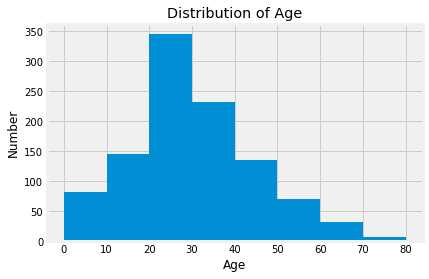

In [19]:
#check the distribution of numerical variables
plot_histogram('Age', bins=np.arange(0, 90, 10))

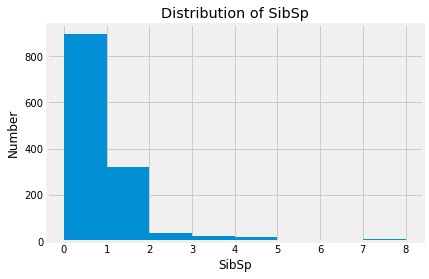

In [20]:
plot_histogram('SibSp', bins=np.arange(0,9,1))

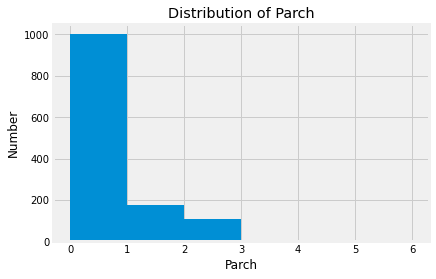

In [21]:
plot_histogram('Parch', bins=np.arange(0, 7, 1))

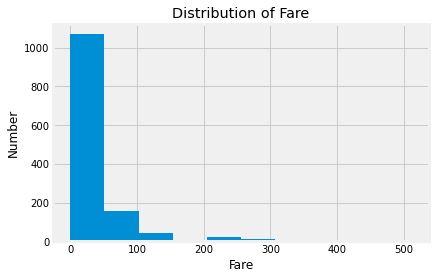

In [22]:
plot_histogram('Fare')

C:\Users\Bofang\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 40.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Bofang\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 73.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Bofang\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 87.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


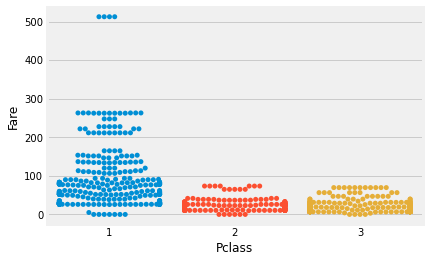

In [23]:
sns.swarmplot(x='Pclass', y='Fare', data=full_df.dropna(subset=['Pclass', 'Fare']));

In [24]:
#obtain descriptive statistics of fares at different pclasses
fares_by_pclasses = {}
for i in range(1,4):
    fares_by_pclasses[i]=full_df.loc[full_df.Pclass==i, 'Fare'].describe()
    
fares_by_pclasses_df = pd.concat([v[1] for v in fares_by_pclasses.items()], axis=1)
fares_by_pclasses_df.columns=['Pclass ' + str(i) for i in range(1, 4)]
print("Fares' distribution in each Pclass:")
display(fares_by_pclasses_df)

Fares' distribution in each Pclass:


,Pclass 1,Pclass 2,Pclass 3
count,323.000000,277.000000,708.000000
mean,87.508992,21.179196,13.266166
std,80.447178,13.607122,11.493776
min,0.000000,0.000000,0.000000
25%,30.695800,13.000000,7.750000
50%,60.000000,15.045800,8.050000
75%,107.662500,26.000000,15.100000
max,512.329200,73.500000,69.550000


**Analysis on the distribution of numerical variables:**

'Age': relatively normal.  
'Sibsp', 'Parch', 'Fare': not normal, right skewed. Replace them with their log, square root or inverse values may help remove the skewness and minimize the extreme values' impact on the algorithms.  

Usually, the fares are much related with the classes. It applied to this case, as confirmed by the correlation analysis in the section [Correlation between variables](#Correlation-between-variables). According to the descriptive statistics, the fare median increases a lot (8->15->60) when the Pclass value decreases (3->2->1).  
However, something unusal was spotted. The fares vary greatly in each class (max/median 5~9). What's worse, all three pclasses overlapped in the fare range below 100. It's further analyzed in the the section [Fare_sharing?](#Fare-sharing?)

### Data distribution of categorical variables

In [25]:
#List the names of the categorical columns which have fewer than 10 categories
cols_few_cat = ['Survived', 'Pclass', 'Sex', 'Embarked']
#List the names of the categorical columns which have more than 10 categories but fewer than 891 categories
cols_many_cat= ['Ticket', 'Cabin']

#### Categorical columns which have only a few categories

In [26]:
#List the value percentages of the categorical columns which have only a few categories
for col in cols_few_cat:
    print('Column Name:', col)
    print(full_df[col].value_counts(normalize=True))
    print('')

Column Name: Survived
0.0    0.616162
1.0    0.383838
Name: Survived, dtype: float64

Column Name: Pclass
3    0.541635
1    0.246753
2    0.211612
Name: Pclass, dtype: float64

Column Name: Sex
male      0.644003
female    0.355997
Name: Sex, dtype: float64

Column Name: Embarked
S    0.699311
C    0.206580
Q    0.094109
Name: Embarked, dtype: float64



#### Categorical columns which have many categories

In [27]:
#check for duplicated values, this 'value' means the number of samples sharing the same value, 
for col in cols_many_cat:
    value_counts = full_df[col].value_counts()
    duplicated_value_counts = value_counts.value_counts()
    duplicated_value_counts_df = duplicated_value_counts.to_frame()
    duplicated_value_counts_df.reset_index(inplace=True)
    duplicated_value_counts_df.rename(columns={'index': 'number of duplicated samples per uniuqe value', col: 'number of unique values'}, \
                                     inplace=True)
    print('Duplicated value counts of {}'.format(col))
    print(duplicated_value_counts_df)
    print('')

Duplicated value counts of Ticket
   number of duplicated samples per uniuqe value  number of unique values
0                                              1                      713
1                                              2                      132
2                                              3                       49
3                                              4                       16
4                                              5                        7
5                                              7                        5
6                                              6                        4
7                                              8                        2
8                                             11                        1

Duplicated value counts of Cabin
   number of duplicated samples per uniuqe value  number of unique values
0                                              1                      107
1                                           

**Finding and analysis of categorical variables and fare-sharing:**  
The victims were twice as many as the survivors. Clearly, this is an imbalanced classfication task.  
The istributions of 'Pclass', 'Sex', 'Embarked' are also imbalanced.

'Cabin' and 'Ticket' have several hundreds of categories. Many of them only appear in one sample record.Some cabins accomodated more than one passengers. It makes sense. What suprised me was that many passengers had the same 'Ticket' numbers and fares. Of the 60 records I checked, according to the names and [encyclopedia-titanic](https://www.encyclopedia-titanica.org/), the ticket-sharing passengers may be somehow related (family members, employer & maid & valet, colleagues).The fare values of their records is the total value of all of them. So their fare values are much higher than the others.The detailed analysis of the fare variable is included in a separate notebook.

### Check the relationship between Survived and other variables

#### Check how survival rates vary with the numerical variables

In [28]:
#compare the variation of variable values (median) by Survived
pd.pivot_table(full_df, index='Survived', values=cols_num, aggfunc=np.median)

,Age,Fare,Parch,SibSp
Survived,,,,
0.0,28.0,10.5,0,0
1.0,28.0,26.0,0,0


In [29]:
#check the median values of the passengers whose ticket numbers were unique
#firstly group the records by ticket numbers and count each groups
ticket_group_sizes = full_df.groupby('Ticket').size()

#secondly create a new feature 'Ticket_group_size'    
full_df['Ticket_group_size'] = full_df['Ticket'].apply(lambda x: ticket_group_sizes[x])
pd.pivot_table(full_df[full_df.Ticket_group_size==1], index='Survived', \
               values=['Fare'], aggfunc=np.median)

,Fare
Survived,
0.0,7.925
1.0,10.500


**Finding:**  
Between the survivors and the victims, the median values are close of these numerical variables except for fare.

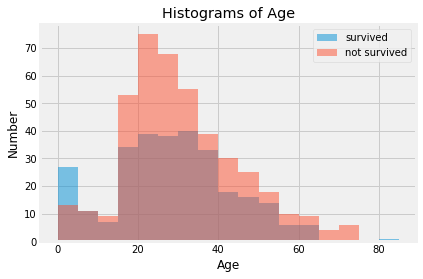

In [30]:
compare_hists('Age', bins=np.arange(0, 90, 5))

**Finding:**  
The passengers under 15 (esp under 5) had much higher survival rates than the rest.  
Very few passengers over 65 survived.

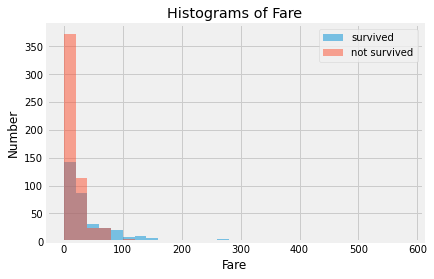

In [31]:
compare_hists('Fare', bins=np.arange(0, 600, 20), df=full_df)

**Finding:**  
The passengersthose with fares below 40 (esp 20) had much lower survival rates than the rest.

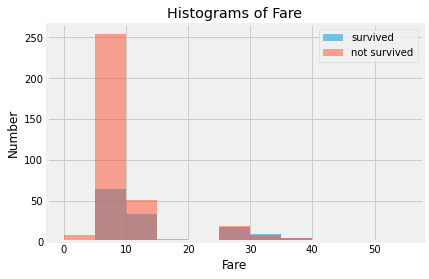

In [32]:
#half of the passengers shared the fares with some other(s)
#only the non-sharing records are selected for this comparison
compare_hists('Fare', bins=np.arange(0, 60, 5), df=full_df[full_df.Ticket_group_size==1])

**Finding:**  
Among the passengers who did not share the fares, those with fares below 10 had much lower survival rates than the rest.

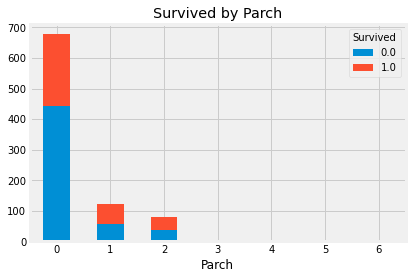

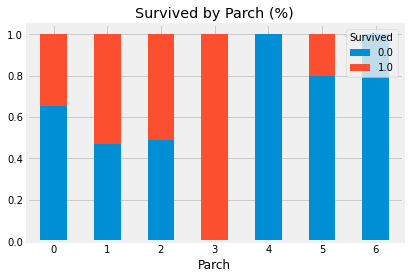

In [33]:
stack_bar('Parch')

**Finding:**  
Very few passengers had 3 or more (max 6) accompanying parches (short for parents and children).   
The passengers with 1 or 2 parch(es) had much higher survival rates than those without any.

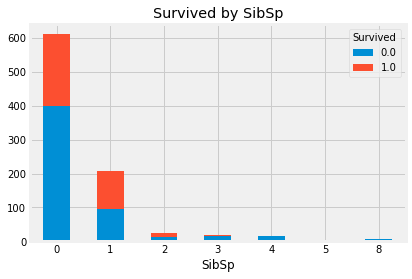

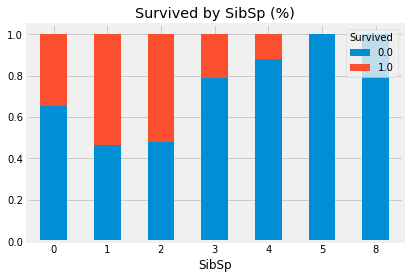

In [34]:
stack_bar('SibSp')

**Finding:**  
Very few passengers had more than one accompanying sibsp (short for sibling and spouse). The max sibsp value is 8.
The passengers with one accompanying sibling and spous had much higher survival rates than those who without any.

#### Check how survival rates vary with the categorical variables

In [35]:
#Check the categorical variables with only a few unique values
for col in cols_few_cat[1:]:
    table = pd.pivot_table(full_df, index='Survived', columns=col, values='PassengerId', aggfunc='count', margins=True)
    print('Survival rates (%) varied by {}:'.format(col))
    display(round(100*table.iloc[[1], :-1].div(table.iloc[-1, :-1], axis=1)))
    print('')

Survival rates (%) varied by Pclass:


Pclass,1,2,3
Survived,,,
1.0,63.0,47.0,24.0



Survival rates (%) varied by Sex:


Sex,female,male
Survived,,
1.0,74.0,19.0



Survival rates (%) varied by Embarked:


Embarked,C,Q,S
Survived,,,
1.0,55.0,39.0,34.0


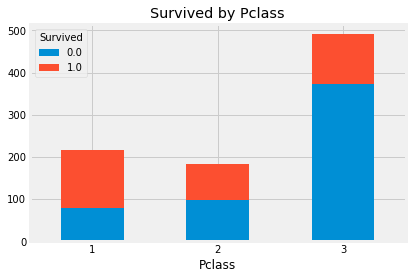

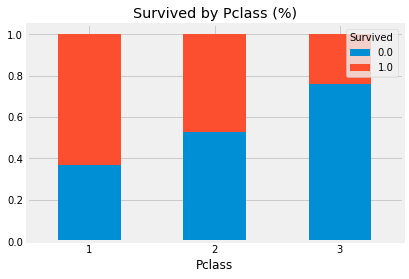

In [36]:
stack_bar('Pclass')

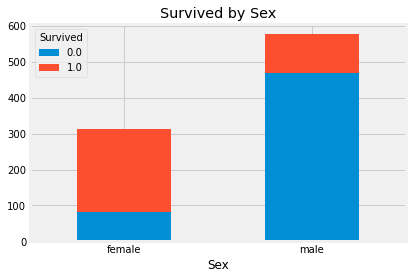

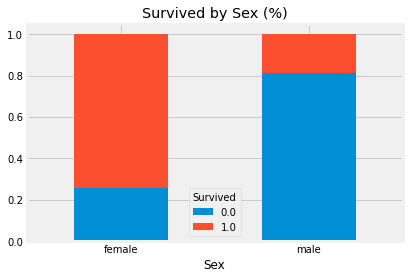

In [37]:
stack_bar('Sex')

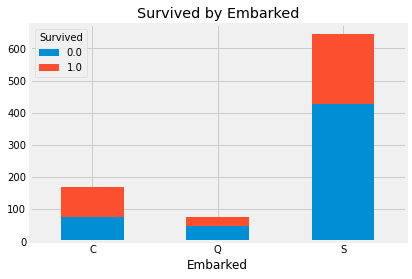

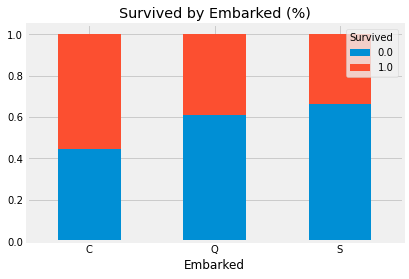

In [38]:
stack_bar('Embarked')

**Finding:**  
The pclass is related with the survival rate, the smaller the pclass value, the higher the survival rates.
The sex is very much related with the survival rate. The female had more than triple as high survival rate as the male.
The passengers who embarked on Q had higher survival rates than those who embarked on S or C.

#### Correlation between variables
According to [Pearson Product-Moment Correlation](https://statistics.laerd.com/statistical-guides/pearson-correlation-coefficient-statistical-guide-2.php) and [Spearman's Rank-Order Correlation](https://statistics.laerd.com/statistical-guides/spearmans-rank-order-correlation-statistical-guide-2.php) from Laerd website:   
Pearson Product-Moment Correlation is between two interval or ratio variables which are normally distributed.As all variables but 'Age' fail to meet this requirement, this method is not appliable.  
Instead, Spearman Rank-Order Correlation method is applicable here for it only requires the variables to be either ordinal, interval or ratio. This method measures the strength and direction of the monotonic relationship between two ranked variables.

In [39]:
#map the sex values to 0 and 1, and create a new column 'Is_female'
full_df['Is_female'] = full_df['Sex'].map({'female': 1, 'male': 0})
full_df.drop('Sex',axis=1,inplace=True)
features = ['Survived', 'Pclass', 'Is_female', 'Age', 'SibSp', 'Parch', 'Fare']
corr_spearman = full_df[features].corr(method='spearman')['Survived']
corr_spearman

Survived     1.000000
Pclass      -0.339668
Is_female    0.543351
Age         -0.051146
SibSp        0.084307
Parch        0.135611
Fare         0.326285
Name: Survived, dtype: float64

,Survived,Pclass,Is_female,Age,SibSp,Parch,Fare
Survived,1.00,-0.34,0.54,-0.05,0.08,0.14,0.33
Pclass,-0.34,1.00,-0.12,-0.39,-0.07,-0.03,-0.71
Is_female,0.54,-0.12,1.00,-0.06,0.17,0.24,0.24
Age,-0.05,-0.39,-0.06,1.00,-0.14,-0.21,0.19
SibSp,0.08,-0.07,0.17,-0.14,1.00,0.43,0.45
Parch,0.14,-0.03,0.24,-0.21,0.43,1.00,0.41
Fare,0.33,-0.71,0.24,0.19,0.45,0.41,1.00


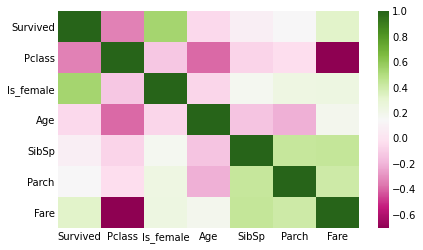

In [40]:
#use heatmap for visualization and choose contrast colors for a more clear view
display(round(full_df[features].corr(method='spearman'), 2))
sns.heatmap(full_df[features].corr(method='spearman'), cmap="PiYG");

In [41]:
#check the correlation between Fare and Pclass after removing the records containing the shared ticket numbers
tickets_not_shared = full_df[full_df.Ticket_group_size==1]
round(tickets_not_shared[['Fare', 'Pclass']].corr(method='spearman').iloc[0,1], 2)

-0.77

**Finding and analysis**  
The top 3 most related variables for Survived: Is_female (0.54), Pclass (-0.33), Fare (0.32).
Among these three, Pclass and Fare are strongly correlated (-0.71).Excluding the records containing the shared ticket values, their correlation got stronger (-0.77).  
Among all the variables, Age has the most weak correlation with Survived (-0.05), indicating very weak monotonic relationship.This doesn't necessarily mean that the passengers of different ages had the same survival rate. The above analysis shows that the children had a much higher survival rate and the elderly had a much lower survival rates.